Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types Based On Centrality, Duration And Cyclic Time

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling via MinMaxScaler
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="white")

from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import time
# import numpy as np

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select only dist features (based on manuelly defined trip types in literature) and id + vehicleType for later interpretation
############################
#SAMPLE
#dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday']].copy()
#df = dfa.sample(n=10000, random_state=1).copy()

df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday']].copy()

# convert duration into minutes
df['duration'] = df['duration'] / 60
# create cyclic hour variables
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)
# create cyclic weekday variables
df['sin_weekday'] = np.sin(2*np.pi*df.weekday / 7)
df['cos_weekday'] = np.cos(2*np.pi*df.weekday / 7)

df

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,sin_hour,cos_hour,sin_weekday,cos_weekday
0,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzE5MTQy,car,5055,4787,9.916667,13,0,-0.258819,-0.965926,0.000000,1.000000
1,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIxNTM2,car,486,948,19.950000,13,0,-0.258819,-0.965926,0.000000,1.000000
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzcyNDA3,car,2049,4820,19.950000,13,0,-0.258819,-0.965926,0.000000,1.000000
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkwNTc5,car,2943,3727,24.933333,13,0,-0.258819,-0.965926,0.000000,1.000000
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzNjQy,car,5268,2697,24.933333,13,0,-0.258819,-0.965926,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
404858,YmlrZTo6dGllcjo6YTFlMmYzZjEtNjkyZS00NjA4LWE5YT...,scooter,179,382,10.000000,23,5,-0.258819,0.965926,-0.974928,-0.222521
404859,YmlrZTo6dGllcjo6OGUxYjAwNDUtMDY3NS00Mzc4LTk3Yz...,scooter,3602,4204,15.033333,23,5,-0.258819,0.965926,-0.974928,-0.222521
404860,YmlrZTo6dGllcjo6ZGE1NmNkMDgtN2Q5ZS00YzE0LWI2OT...,scooter,2007,3149,15.033333,23,5,-0.258819,0.965926,-0.974928,-0.222521
404861,YmlrZTo6dGllcjo6NzRlY2JjZTYtZWQ3Yi00ZGY3LWJmMG...,scooter,2801,2958,5.000000,23,5,-0.258819,0.965926,-0.974928,-0.222521


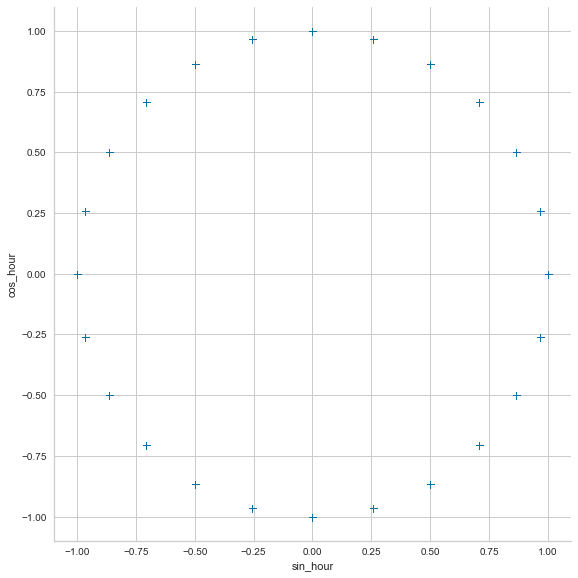

In [6]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_hour", y="cos_hour", kind="scatter", data=df, marker='+', height=8, aspect=1)

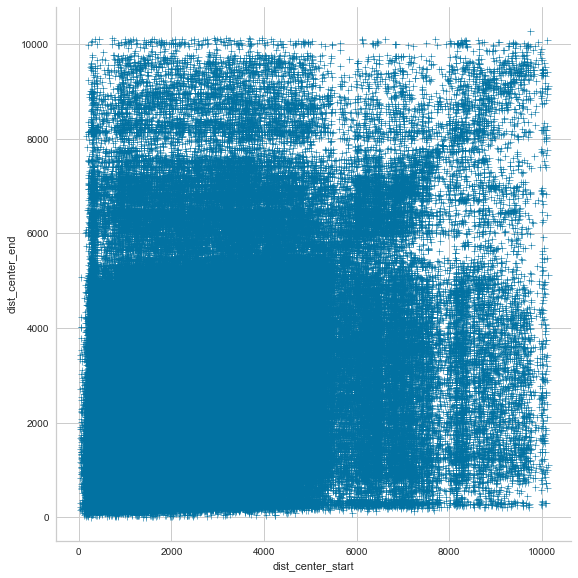

In [7]:
# remove extreme outliers due to sensibility of k-means regarding outliers
# has to be considered that trips outside the operation area or to and from isolated operation areas (e.g. airport) are removed
df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)].reset_index(drop=True)
#df = df.drop(df[(df['dist_center_start']>11000)&(df['dist_center_end']>11000)].index, inplace=True)

# plot result
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=8, aspect=1)

### Feature scaling

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration'),
  Text(3, 0, 'hour'),
  Text(4, 0, 'weekday'),
  Text(5, 0, 'sin_hour'),
  Text(6, 0, 'cos_hour'),
  Text(7, 0, 'sin_weekday'),
  Text(8, 0, 'cos_weekday')])

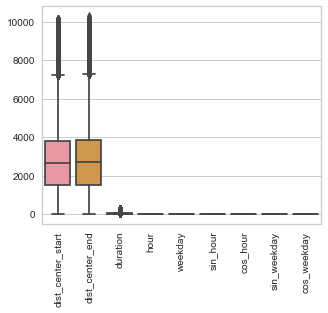

In [8]:
# look at feature skewness
plt.figure(figsize=(5,4))
sns.boxplot(data=df)
plt.xticks(rotation=90)

In [9]:
# normalize features to get same range as sin and cos values
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

dfnorm = df[['dist_center_start','dist_center_end', 'duration']].copy()

# column names
names = dfnorm.columns
# create scaler object
scaler = StandardScaler()
# fit data on scaler object
dfnorm = scaler.fit_transform(dfnorm)
dfnorm = pd.DataFrame(dfnorm, columns=names)
# normalize data
dfnorm = normalize(dfnorm) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(dfnorm, columns=names) 

scaled_df = df[['sin_hour','cos_hour','sin_weekday','cos_weekday']].copy()
scaled_df = pd.concat([scaled_df, normalized_df], axis=1)
scaled_df

# assign weight to variables to compensate for double appearance of time related features
feature_weight = 1.75
scaled_df['duration'] = scaled_df['duration'] * feature_weight
scaled_df['dist_center_start'] = scaled_df['dist_center_start'] * feature_weight
scaled_df['dist_center_end'] = scaled_df['dist_center_end'] * feature_weight

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'sin_hour'),
  Text(1, 0, 'cos_hour'),
  Text(2, 0, 'sin_weekday'),
  Text(3, 0, 'cos_weekday'),
  Text(4, 0, 'dist_center_start'),
  Text(5, 0, 'dist_center_end'),
  Text(6, 0, 'duration')])

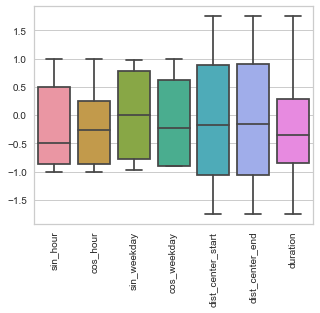

In [10]:
# visualize scaled features (still right skewed but scaled from 0 to 1 + 0 remains)
plt.figure(figsize=(5,4))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)

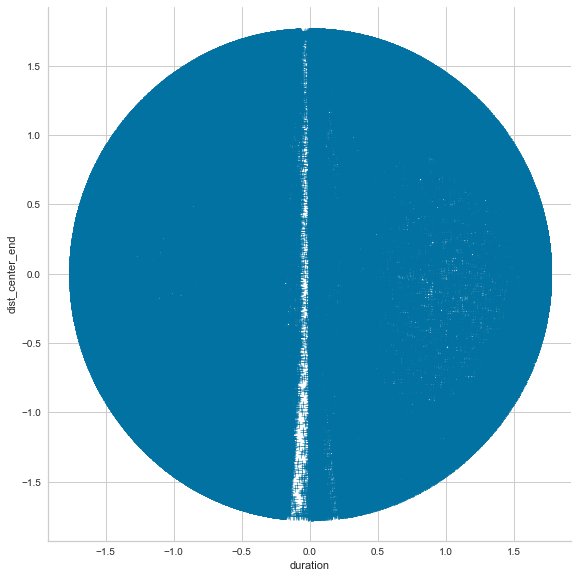

In [11]:
# plot still indicates four interpretable convex clusters
g = sns.relplot(x="duration", y="dist_center_end", kind="scatter", data=scaled_df, marker='+', height=8, aspect=1)

### Cluster tendency

In [12]:
# calculate hopkins statistics on subset
from pyclustertend import hopkins
hopkins(scaled_df, 10000)

0.06643507320933413

### Clustering trip types via k-means and parameter selection

#### Parameter selection / clustering performance evaluation

In [13]:
# run k-means multiple times to identify "optimal" k
from sklearn import metrics
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# calinski_harabasz_score
calinski_harabasz_scores = []

# davies_bouldin_score
davies_bouldin_scores = []

# run loop
for i in range (2,20):   
    start = time.time()
    
    kmeans = KMeans(i)
    kmeans.fit(scaled_df)
    
    wcss.append(kmeans.inertia_)
    print(kmeans.inertia_)
        
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print(score)
    
    score_cal = metrics.calinski_harabasz_score(scaled_df, kmeans.labels_)
    calinski_harabasz_scores.append(score_cal)
    print(score_cal)
    
    score_db = davies_bouldin_score(scaled_df, kmeans.labels_)
    davies_bouldin_scores.append(score_db)
    print(score_db)

    end = time.time()
    print(i)
    print(end - start)

1513441.764025423
0.2199033539754122
119915.52348935649
1.8039753752658338
2
2546.872257232666
1321542.7570077616
0.2009277233597357
97823.38398075265
1.8033252887238274
3
2482.3045129776
1193730.186599549
0.1885675890472069
86531.89398705699
1.7040093885573913
4
2466.2267260551453
1101870.3065217678
0.18769594250373411
78679.1934440437
1.6215824518027713
5
2457.6695091724396
1039123.5533895185
0.16176059052778016
71594.36464268429
1.808604268324079
6
2459.222286462784
991251.3893321977
0.1558339387090141
65775.84306542935
1.8878760998452153
7
2464.000819206238
954201.0142744068
0.15291339259394562
60796.00594786482
1.8338492876745178
8
2458.264486551285
916645.8984272088
0.14810735414315596
57432.59238144024
1.7816834840148472
9
2465.529794216156
885326.4439484992
0.14988036036345712
54435.72287036758
1.8087059520740212
10
2467.3709075450897
861955.9854293411
0.1469379722621113
51409.12312056107
1.7909507026537221
11
2469.094316005707
836681.9800774133
0.1497054681930589
49250.2100725

#### Elbow method

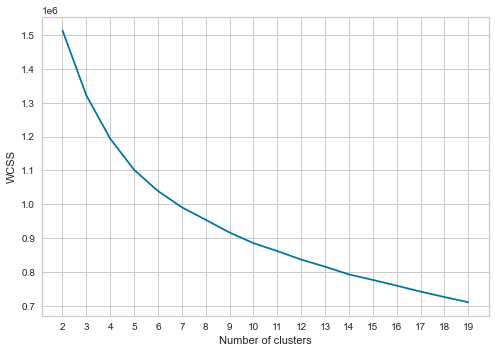

In [14]:
# plot wcss for each k
plt.plot(range(2, 20), wcss)
plt.xticks(range(2, 20))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

#### Silhouette coefficient

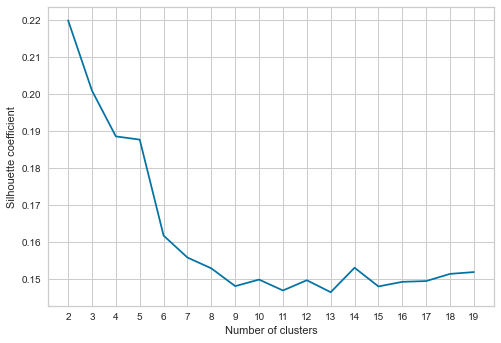

In [15]:
# plot silhouette coefficients for each k
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

# silhouette score EXTREMELY high running time
if (False):
    model = KMeans(random_state=0)

    # select range of cluster number and the metric to observe costs
    visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False)

    # fit and visualize
    visualizer.fit(scaled_df)    
    visualizer.poof()

#### Calinski Harabasz score

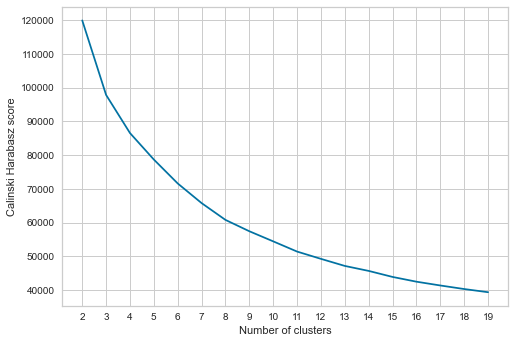

In [16]:
# plot Calinski Harabasz score for each k
plt.plot(range(2, 20), calinski_harabasz_scores)
plt.xticks(range(2, 20))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabasz score")
plt.show()

#### Davies Bouldin score

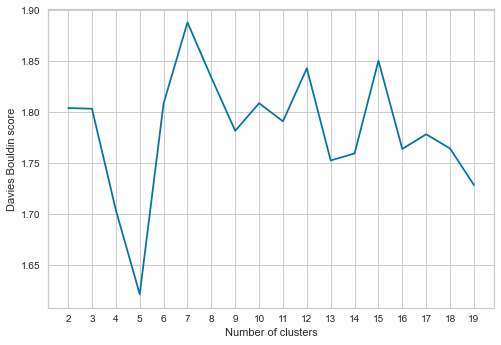

In [17]:
# plot Davies Bouldin scores for each k
plt.plot(range(2, 20), davies_bouldin_scores)
plt.xticks(range(2, 20))
plt.xlabel("Number of clusters")
plt.ylabel("Davies Bouldin score")
plt.show()

#### K-means with selected parameter

In [ ]:
# cluster data for the chosen number of clusters
k = 5

kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_df)

clustered_data = df.copy()

clustered_data['cluster'] = kmeans.fit_predict(scaled_df)


clustered_data

### Interpretation and visualization of results

* cluster: inner-inner trips
* cluster: outer-outer trips
* cluster: outer-inner trips
* cluster: inner-outer trips

#### Cluster cardinality

In [ ]:
# show cardinality (sum of instances) of clusters
sns.countplot(x="cluster", data=clustered_data, palette='rainbow')

#### Cluster magnitude

In [ ]:

#distances = kmeans.fit_transform(scaled_df)
#variance = 0
#i = 0
#for label in kmeans.labels_:
#    variance = variance + distances[i][label]
#    i = i + 1
#variance

#for kmeans.labels_
#inertia_0

#### Cardinality vs magnitude

#### Attribute table

In [ ]:
interpret_df = clustered_data[['dist_center_start','dist_center_end','duration','cluster']].copy()
interpret_df = interpret_df.groupby(['cluster']).mean()


time_df = clustered_data[['weekday','hour','cluster']].copy()

dayOfWeek={0:'0 Monday', 1:'1 Tuesday', 2:'2 Wednesday', 3:'3 Thursday', 4:'4 Friday', 5:'5 Saturday', 6:'6 Sunday'}
time_df['weekday'] = time_df['weekday'].map(dayOfWeek)
time_df = time_df.join(pd.get_dummies(time_df['weekday']))
time_df = time_df.drop(['weekday'],axis=1)

time_df = time_df.join(pd.get_dummies(time_df['hour']))
time_df = time_df.drop(['hour'],axis=1)

time_df = time_df.groupby(['cluster']).sum()

count = clustered_data.groupby(['cluster'])['id'].count().copy()

for i in count.index:
    for col in time_df.columns:
        time_df[col][i] = time_df[col][i] / count[i] * 100

interpret_df = interpret_df.join(time_df)


pd.set_option("display.max_rows", None, "display.max_columns", None)
interpret_df.T.round(2)

In [ ]:
# plot cluster results
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=clustered_data, marker='+', hue='cluster', palette='rainbow', legend='full', height=8, aspect=1)

In [23]:
sampleTSNE = scaled_df.sample(n=50000, random_state=1)
# cluster data for the chosen number of clusters
k = 9
k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
clusters = k_means_new.fit_predict(sampleTSNE)
sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X = sampleTSNE.iloc[:,:-1]
##########################################
tsne = TSNE(n_components=2, perplexity=100.0, n_iter=5000, verbose=1).fit_transform(X)

tsne

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.117s...
[t-SNE] Computed neighbors for 50000 samples in 9.870s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

array([[ 98.13439 ,  33.49753 ],
       [-42.112156, 119.60375 ],
       [-36.059795,  91.1263  ],
       ...,
       [-91.012924,  75.72065 ],
       [ 37.25043 ,  22.207148],
       [-32.569416, -80.407104]], dtype=float32)

In [24]:
tsne_cluster = pd.DataFrame(tsne)
tsne_cluster['cluster'] = clusters
tsne_cluster.columns = ['x1','x2','cluster']

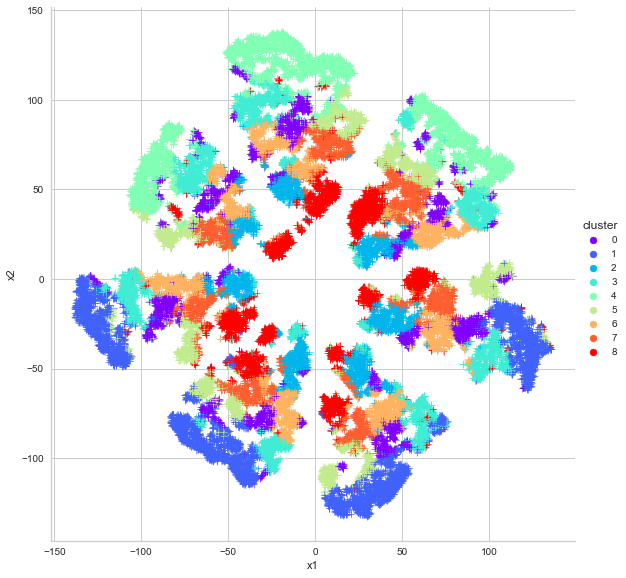

In [25]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster, hue='cluster', marker='+', palette ='rainbow', legend="full", height=8, aspect=1)

### Distribution of trip types among mobility modes

In [26]:
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution [%]'] = distribution['id'] / trip_volume *100

    return distribution[['Distribution [%]']]

In [27]:
create_distribution_overview('car')

,Distribution [%]
cluster,
0,17.779786
1,4.405435
2,12.613839
3,15.282850
4,18.784585
5,6.335392
6,14.779831
7,6.956016
8,3.062265


In [28]:
create_distribution_overview('bicycle')

,Distribution [%]
cluster,
0,8.619270
1,14.332771
2,4.403749
3,5.093918
4,8.462413
5,16.846398
6,9.783930
7,17.281675
8,15.175875


In [29]:
create_distribution_overview('scooter')

,Distribution [%]
cluster,
0,4.528942
1,15.684237
2,4.715811
3,7.638432
4,3.170035
5,20.028553
6,1.163069
7,24.991030
8,18.079890
